In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup 
import pandas as pd 
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from typing import Container
from pickle import GLOBAL
import random 
import time

In [5]:
# driver = webdriver.Chrome(executable_path=r'chromedriver.exe')

def raspar(url):
    options = webdriver.ChromeOptions()
    # options.add_argument("--headless")

    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
    driver.get(url)

    #clica no botão dos reviews
    botaoreviews = '//*[@id="__next"]/main/div/section[1]/section/div[3]/section/section/div[3]/div[2]/div[1]/div[2]/div/div[1]/a'
    driver.find_element(By.XPATH, botaoreviews).click()

    #clica no botão dos reviews de usuários, por ser mais fácil de raspar. 
    #Reviews externos poderiam ser dados mais interessantes e robustos, mas são sites diferentes.
    userreviewslink = '//*[@id="sidebar"]/div[3]/ul/li[3]/a'
    driver.find_element(By.XPATH, userreviewslink).click()

    #esse elemento contém o número total de reviews.
    totalreviews = '/html/body/div[2]/div/div[2]/div[3]/div[1]/section/div[2]/div[1]/div/span'

    #transforma o elemento em texto
    trtext = driver.find_element(By.XPATH, totalreviews)
    trtext = trtext.text

    #remove a palavra, ficando só o número (índice 0, já que sempre vem primeiro)
    trtextlist = trtext.split(' ')
    onlynumbertrtext = trtextlist[0]

    #se for um número acima de mil, ele coloca um ponto, exemplo: 1.777
    #tentar transformar isso em número não daria certo, então quando necessário ele remove esse ponto.
    onlynumbertrtext = onlynumbertrtext.replace('.', '')

    #transformando em inteiro
    onlynumbertrtext = int(onlynumbertrtext)

    #não sei onde mais incluir essa informação mas talvez seja pertinente?
    print('Essa página do imdb tem um total de {} reviews! Incrível.'.format(onlynumbertrtext))

    #elemento do botão de load more
    loadmore = '//*[@id="load-more-trigger"]'

    #imdb mostra 25 reviews por vez
    #dividir por 25 o número de reviews para saber o tanto de vezes que clico no load more
    vezesaclicar = onlynumbertrtext/25

    contador = 1
    while contador < vezesaclicar:

        try:
            clicaloadmore =  driver.find_element(By.XPATH, loadmore).click()
            driver.implicitly_wait(random.randint(1, 5)) #tentar evitar ser flaggado como robô 
        except:
            pass
        print('clicando pela {}º vez!'.format(contador))
        contador+=1
        
    #hora da raspagem

    #pegar todos os elementos q tenham esse nome
    review = driver.find_elements(By.CLASS_NAME, 'review-container')
    
    #listas para armazenar os dados
    title = []
    content = []
    rating = []
    date = []
    user_name = []

    for n in range(0,onlynumbertrtext): #temos o número certinho de repetições a serem feitas
                print('raspando o {}º review, total: {}'.format(n, onlynumbertrtext))
                time.sleep(random.randint(2,7)) #tentar evitar do imdb me fuder
                try:
                    #encontrando os elementos a serem raspados
                    ftitle = review[n].find_element(By.CLASS_NAME, 'title').text
                    fcontent = review[n].find_element(By.CLASS_NAME, 'content').get_attribute("textContent").strip()
                    frating = review[n].find_element(By.CLASS_NAME, 'rating-other-user-rating').text
                    fdate = review[n].find_element(By.CLASS_NAME, 'review-date').text
                    fname = review[n].find_element(By.CLASS_NAME, 'display-name-link').text

                    #adicionar às suas listas
                    title.append(ftitle)
                    content.append(fcontent)
                    rating.append(frating)
                    date.append(fdate)
                    user_name.append(fname)
                except:
                    continue

    data = {'User_name': user_name, 
                'Review title': title, 
                'Review Rating': rating,
                'Review date' : date,
                'Review_body' : content
            }
    
    global reviewdata #pra ser acessado de fora da função

    reviewdata = pd.DataFrame(data = data)

    driver.quit()


In [15]:
def limpardados():
    #limpar coluna de review body
    #a raspagem pegou junk data que atrapalha na geração das word clouds
    #através disso eu tento limpar esses dados
    reviewdata['Review_body'] = reviewdata['Review_body'].str.rstrip('''    Was this review helpful?  Sign in to vote.
                            
                            
                        "''')

    emptydelimiter = '''                
                        '''

    reviewdata.Review_body.str.replace("({}).*".format(emptydelimiter),"")

    reviewdata['Review_body'] = reviewdata['Review_body'].str.rstrip(' out of ')

    reviewdata['Review_body'] = reviewdata['Review_body'].str.replace('Permalink', '')
    reviewdata['Review_body'] = reviewdata['Review_body'].str.replace('found this helpful.', '')

    new = reviewdata['Review_body'].str.split(emptydelimiter, n = 1, expand = True)
    reviewdata["Clean_Review_body"]= new[0]
    


In [11]:
#gerar wordcloud
def gera_wordcloud():
	comment_words = ''
	stopwords = set(STOPWORDS)

	# iterate through the csv file
	for val in reviewdata['Review_body']:
		
		# typecaste each val to string
		val = str(val)

		# split the value
		tokens = val.split()
		
		# Converts each token into lowercase
		for i in range(len(tokens)):
			tokens[i] = tokens[i].lower()
		
		comment_words += " ".join(tokens)+" "

	wordcloud = WordCloud(width = 1600, height = 800,
					background_color ='white',
					stopwords = stopwords,
					min_font_size = 10).generate(comment_words)

	# plot the WordCloud image					
	plt.figure(figsize = (8, 8), facecolor = None)
	plt.imshow(wordcloud)
	plt.axis("off")
	plt.tight_layout(pad = 0)

	plt.show()

In [6]:
#aceita url de mídia principal do imdb
raspar('https://www.imdb.com/title/tt9253284/?ref_=fn_al_tt_1')

C:\Users\Lain-PC\AppData\Local\Temp\ipykernel_9128\3899314128.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
C:\Users\Lain-PC\AppData\Local\Temp\ipykernel_9128\3899314128.py:7: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)


Essa página do imdb tem um total de 452 reviews! Incrível.
clicando pela 1º vez!
clicando pela 2º vez!
clicando pela 3º vez!
clicando pela 4º vez!
clicando pela 5º vez!
clicando pela 6º vez!
clicando pela 7º vez!
clicando pela 8º vez!
clicando pela 9º vez!
clicando pela 10º vez!
clicando pela 11º vez!
clicando pela 12º vez!
clicando pela 13º vez!
clicando pela 14º vez!
clicando pela 15º vez!
clicando pela 16º vez!
clicando pela 17º vez!
clicando pela 18º vez!
raspando o 0º review, total: 452
raspando o 1º review, total: 452
raspando o 2º review, total: 452
raspando o 3º review, total: 452
raspando o 4º review, total: 452
raspando o 5º review, total: 452
raspando o 6º review, total: 452
raspando o 7º review, total: 452
raspando o 8º review, total: 452
raspando o 9º review, total: 452
raspando o 10º review, total: 452
raspando o 11º review, total: 452
raspando o 12º review, total: 452
raspando o 13º review, total: 452
raspando o 14º review, total: 452
raspando o 15º review, total: 452
ra

In [7]:
reviewdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_name      447 non-null    object
 1   Review title   447 non-null    object
 2   Review Rating  447 non-null    object
 3   Review date    447 non-null    object
 4   Review_body    447 non-null    object
dtypes: object(5)
memory usage: 17.6+ KB


In [8]:
reviewdata

,User_name,Review title,Review Rating,Review date,Review_body
0,jaimemedina-36288,"And, or? Maybe? Yes indeed",9/10,12 October 2022,"This is, minute for minute, some of the best t..."
1,poseyfan,The sheer grittiness and adult tones are a gla...,10/10,13 October 2022,Andor takes crap seriously and it's refreshing...
2,Dimakovtun,Best SW series so far (6 episodes S1),8/10,12 October 2022,"Seeing all the other series, Andor provides a ..."
3,ROOKreations,A Welcome New Tone,9/10,21 September 2022,"First of all, wow! The show immediately grabs ..."
4,Supermanfan-13,Pretty Entertaining!,9/10,24 October 2022,Andor was every bit as good as I was hoping fo...
...,...,...,...,...,...
442,chelfyn-05590,Finally something good from Disney Star Wars,9/10,24 September 2022,The rich tapestry of Star Wars has needed this...
443,liamjhunter-54857,The Star Wars I've been waiting for,10/10,23 September 2022,While this series begins with a very slow star...
444,grizzla-44040,Captivating Ep1-3,8/10,22 September 2022,The different music scores are fantastic and o...
445,tim-haemel,lightyears above other SW series,9/10,25 September 2022,"Actors/acting, hole production level, set buil..."


In [17]:
limpardados()
#gera_wordcloud()

reviewbody = reviewdata['Clean_Review_body']
reviewbody.to_csv('reviewbodyclean.txt')

reviewbody = reviewdata['Review_body']
reviewbody.to_csv('reviewbody.txt')


C:\Users\Lain-PC\AppData\Local\Temp\ipykernel_9128\4061628819.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  reviewdata.Review_body.str.replace("({}).*".format(emptydelimiter),"")
C:\Users\Lain-PC\AppData\Local\Temp\ipykernel_9128\4061628819.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  reviewdata['Review_body'] = reviewdata['Review_body'].str.replace('found this helpful.', '')


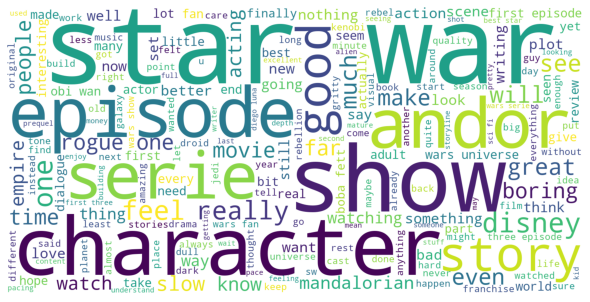

In [18]:
gera_wordcloud()


In [5]:
# print('''
# ======================================================
#                  IMDB review scraper
# ======================================================

# ''')

# def vaidireto():
#     print('foo')

# def pesquisa_imdb():
#     print('bar')


# def perguntar():
#     y = input('Inserir url (digite 1) ou pesquisar nome de filme (digite 2)?\n')
#     if y == '1':
#         vaidireto()
#     elif y == '2':
#         pesquisa_imdb()
#     else:
#         perguntar()

# perguntar()








# driver = webdriver.Chrome(executable_path=r'chromedriver.exe')



                 IMDB review scraper

Alunos: Pedro Moura e Rebeca Marina

